``https://github.com/hhk998402/Time-Series-Forecasting-SARIMAX/blob/master/Hemant_Sangam.ipynb``

<b>Approach used:</b> SARIMAX (Seasonal Autoregressive Integrated Moving Average with eXogeneous variables)

<b> Reason:</b> The data provided is seasonal, and it is a time series data with multiple exogeneous variables influencing the result. Hence, the optimal statistical model that can be applied to this task is SARIMAX

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from tqdm import tqdm
import statsmodels.api as sm
import seaborn as sns
import pandas as pd
import numpy as np
import itertools
import warnings

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')

Open and store the dataset as a pandas dataframe

In [ ]:
# get data
df = pd.read_csv("../data/complete-merged-df.csv", index_col=0, parse_dates=True)
df.head()

Prepare the data:

- Split the data into train and test samples
- Create `endog` and `exog` variables


In [ ]:
# split data into train and test
top_predictors = ['close','open', 'high', 'low', 'n-transactions', 'cost-per-transaction',
                  'Gold price', 'output-volume',  'USD-CNY Price', 'SVI', 'Wikiviews']
df = df[top_predictors]

train, test = train_test_split(df, test_size=0.2, shuffle=False)
# len(train), len(test)

# Variables
exog_data = train.drop(['close'], axis=1)

exog = sm.add_constant(exog_data)
endog = train[['close']]

# # try shifting by 1 to see if it helps
# # NOTE: this is not working
# endog = train[['close']].shift(-1) 
# endog.fillna(endog.iloc[-2].values[0], inplace=True)


Find the best order for the ARIMA model

In [ ]:
# Initial approximation of parameters
Qs = range(0, 2)
qs = range(0, 3)
Ps = range(0, 3)
ps = range(0, 3)
D = 1
d = 1
parameters = itertools.product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

# Model Selection
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')
for param in parameters_list:
    try:
        model = SARIMAX(endog, exog=exog, order=(param[0], d, param[1]), seasonal_order=(param[2], D, param[3], 4)).fit(disp=-1)
    except ValueError:
        print('bad parameter combination:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])


In [ ]:
# Best Models
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by='aic', ascending=True).head())
print(best_model.summary())


Train the model with the train variables with order `(p=1, d=0, q=1)`

In [5]:
# train model

mod = SARIMAX(endog, exog=exog, order=(1, 1, 2), seasonal_order=(0, 1, [1], 4))
fit_res = mod.fit(disp=False)
fit_res.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                               close   No. Observations:                 1460
Model:             SARIMAX(1, 1, 2)x(0, 1, [1], 4)   Log Likelihood               -9619.079
Date:                             Thu, 14 Apr 2022   AIC                          19270.158
Time:                                     19:08:57   BIC                          19354.682
Sample:                                 01-01-2017   HQIC                         19301.694
                                      - 12-30-2020                                         
Covariance Type:                               opg                                         
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                         0      0.002          0      1.000      -0.004       0.004
open                    -0.5134      0.013    -38.688      0.000      -0.539      -0.487
high                     0.8756      0.014     62.765      0.000       0.848       0.903
low                      0.6056      0.008     72.430      0.000       0.589       0.622
n-transactions       -1.276e-05      0.000     -0.052      0.959      -0.000       0.000
cost-per-transaction    -1.5185      0.742     -2.047      0.041      -2.973      -0.065
Gold price              -0.0422      0.069     -0.610      0.542      -0.178       0.093
output-volume        -5.013e-06      1e-05     -0.501      0.617   -2.46e-05    1.46e-05
USD-CNY Price          -55.9615     57.558     -0.972      0.331    -168.773      56.850
SVI                      1.2017      0.725      1.658      0.097      -0.219       2.622
Wikiviews               -0.0008      0.001     -1.254      0.210      -0.002       0.000
ar.L1                   -0.6686      5.582     -0.120      0.905     -11.610      10.273
ma.L1                   -0.1528      5.592     -0.027      0.978     -11.114      10.808
ma.L2                   -0.5464      4.586     -0.119      0.905      -9.534       8.442
ma.S.L4                 -0.6382      0.027    -23.761      0.000      -0.691      -0.586
sigma2                4.691e+04      0.324   1.45e+05      0.000    4.69e+04    4.69e+04
===================================================================================
Ljung-Box (L1) (Q):                  26.58   Jarque-Bera (JB):              8993.24
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.70   Skew:                            -0.31
Prob(H) (two-sided):                  0.00   Kurtosis:                        15.16
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.5e+22. Standard errors may be unstable.
"""

### Breakdown of the summary order=(1, 0, 1)
- The Ljung-Box (L1) (Q) at lag 1 is 0, and the Prob(Q) is 0.99. Since the probability is above 0.05, we can't reject the null that the errors are white noise.
- Heteroscedasticity tests that the error residuals are homoscedastic or have the same variance. Our summary statistics show a test statistic of 0.65 and a p-value of 0.00, which means we reject the null hypothesis and our residuals show variance.
- Jarque-Bera tests for the normality of errors. It tests the null that the data is normally distributed against an alternative of another distribution. We see a test statistic of `13286.64` with a probability of 0, which means we reject the null hypothesis, and the data is not normally distributed. Also, as part of the Jarque-Bera test, we see the distribution has a slight negative skew and a large kurtosis.

In [6]:
# adfuller test
print("Dickey–Fuller test:: p=%f" % sm.tsa.adfuller(fit_res.resid[13:])[1])


Dickey–Fuller test:: p=0.000000


Display the residuals from the model fit in acf and pacf plots

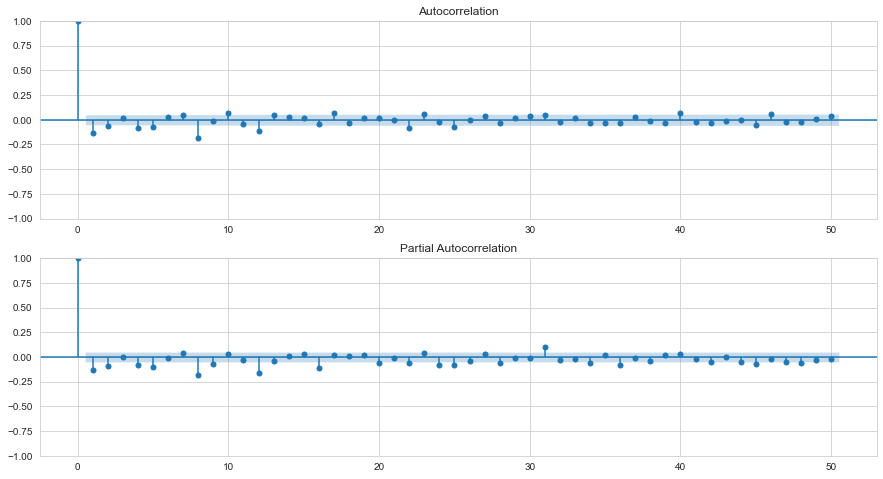

In [7]:
res = fit_res.resid
fig, ax = plt.subplots(2, 1, figsize=(15, 8))
fig = sm.graphics.tsa.plot_acf(res, lags=50, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(res, lags=50, ax=ax[1])
plt.show()

In [8]:
res_df = pd.DataFrame(fit_res.resid, columns=['resid'])
res_df.sort_values(by='resid', ascending=False).head(5)

,resid
2017-12-22,1142.082456
2017-12-07,1065.835034
2020-12-29,1049.335082
2018-01-17,894.897760
2020-03-16,860.642638


The outlier in date `2017-12-22`?

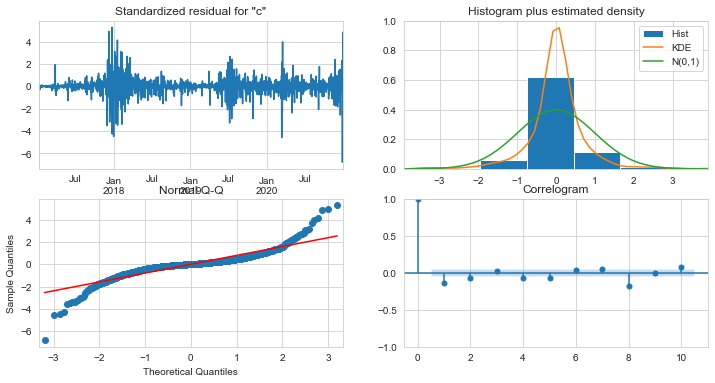

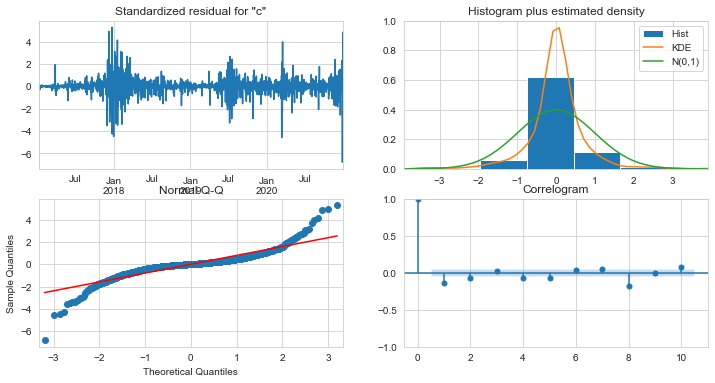

In [9]:
fit_res.plot_diagnostics(figsize=(12, 6))

### Residual analysis of the selected model
- We can see that the residuals have no trend and a fairly constant variance over time, just like white noise. 
- On the top right plot, the distribution of residuals is very close to a normal distribution. 
- This is further supported by the Q-Q plot on the bottom left that shows a fairly straight line that lies on y = x. 
- Finally, the correlogram shows no significant coefficients after lag 0, just like white noise. 

Therefore, from a graphical analysis, the residuals of this model resemble white noise.

In [10]:
# Accuracy metrics
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0, 1]   # corr
    mins = np.amin(np.hstack([forecast[:, None],
                              actual[:, None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:, None],
                              actual[:, None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    
    return({'mape': str(round(mape*100,3))+"%", 'me': me, 'mae': mae,
            'mpe': mpe, 'rmse': rmse, 
            'corr': corr, 'minmax': minmax})


## Now lets test the model's prediction

In [11]:
# test model
first_predict, last_predict = test.iloc[0].name, test.iloc[-1].name

exog1 = (sm.add_constant(test).loc[first_predict:])
exog1 = exog1.drop(['close'], axis=1)

forecast = fit_res.forecast(steps=len(test), exog=exog1)
print(len(forecast), len(test))

result_data = pd.DataFrame(index=test.index, columns=['actual', 'pred'])
# result_data.head()

chk = 0
for i in tqdm(forecast):
    result_data.iloc[chk]["actual"] = df.iloc[df.index == test.iloc[chk].name]['close'].values[0]
    result_data.iloc[chk]["pred"] = i
    chk += 1
    
result_data.head(10)

366 366


100%|██████████| 366/366 [00:00<00:00, 506.93it/s]


,actual,pred
2020-12-31,28984.983403,28100.118082
2021-01-01,29405.123461,29296.750705
2021-01-02,32216.53,32679.345144
2021-01-03,33071.5,34341.980893
2021-01-04,32042.188855,29724.241787
2021-01-05,34043.030762,32736.475373
2021-01-06,36881.170952,36255.705671
2021-01-07,39506.26984,39467.982778
2021-01-08,40652.065835,39053.894316
2021-01-09,40256.346011,39713.38076


In [21]:
# compare the values at a random date from the dataset
sample_date = test.iloc[5].name
y_hat = df.loc[sample_date]['close']
y_pred = result_data[result_data.index == sample_date]["pred"].values[0]

# compare that date with the predicted date
print(F"{sample_date}\n\tActual {y_hat}\n\tPredicted {y_pred}")

# display the forecast accuracy metrics for the test set
forecast_accuracy(forecast, test['close'].values)

2021-01-05 00:00:00
	Actual 34043.030762
	Predicted 32736.47537286769


{'mape': '3.662%',
 'me': 1368.6183181723966,
 'mae': 1663.657918977068,
 'mpe': 0.030251131680097118,
 'rmse': 1991.739217336181,
 'corr': 0.9895135237624146,
 'minmax': 0.03487450706597417}

We can see the predicted value is quite close to the actual value on that date.

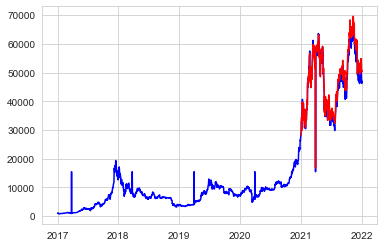

In [15]:
# plot the test data and the predicted data
plt.plot(df['close'], label='test', color='blue')
plt.plot(result_data['pred'], label='predicted', color='red')

The blue label depicts the actual values, while the red label shows the prediction made. <br>
The plot shows us the model has predicted the values closely to the actual values.

### Forecast Tests
- Make a prediction using the model for the next `n-days/months/years`.
- The `get_new_data()` function gets the BPI from Yahoo Finance for the latest/given dates to compare with the predictions.
- Create a `future` DataFrame with the actual and forecasted values
- Create a mask for a short time frame and visualize it in a plot
- Calculate metrics

In [85]:
from datetime import date
from dateutil.relativedelta import relativedelta

n_years = 2
n_days = 365*n_years+1
# n_days = 30

exog_last = sm.add_constant(df.drop(['close'], axis=1))[-n_days:]
start_index = exog.index.max().date() + relativedelta(days=1)
end_index = date(start_index.year+n_years, start_index.month, start_index.day)
# end_index = pd.date_range(df.index[-1], periods=30, freq='1d').tolist()[-1].date()
pred = fit_res.predict(start=start_index, end=end_index, exog=exog_last)

print(start_index, end_index)

2020-12-31 2022-12-31


In [23]:
import yfinance as yf
from yahoofinancials import YahooFinancials

# get new data from yahoo finance
def get_new_data(ticker, start_date, end_date=date.today()):
    data = yf.download(ticker, start=start_date, end=end_date, progress=False)
    return data

In [89]:
yf_df = get_new_data('BTC-USD', df.index[-1])
try:
    print(f"Forecast {pred.iloc[pred.index == '2022-01-05']}")
    print(f"Actual {yf_df.loc['2022-01-05']['Close']}")
except IndexError as e:
    print(f"Cannot find the forecast date (max {end_index})")
    pass


Forecast 2022-01-05    37043.589331
Freq: D, Name: predicted_mean, dtype: float64
Actual 43569.00390625


In [90]:
# create a new dataframe with the actual and predicted values
future = pd.DataFrame(columns=['actual', 'pred', 'train', 'forecast'])
future['forecast'] = pred
future["actual"] = yf_df['Close']
future["pred"] = result_data['pred']
future['train'] = df['close']
future
# yf_df['Close']

,actual,pred,train,forecast
2020-12-31,NaN,28100.118082,28984.983403,7319.320275
2021-01-01,NaN,29296.750705,29405.123461,7652.986152
2021-01-02,NaN,32679.345144,32216.530000,8187.816511
2021-01-03,NaN,34341.980893,33071.500000,8171.061958
2021-01-04,NaN,29724.241787,32042.188855,7618.652652
...,...,...,...,...
2022-12-27,NaN,NaN,NaN,59050.824432
2022-12-28,NaN,NaN,NaN,55969.361359
2022-12-29,NaN,NaN,NaN,53960.047795
2022-12-30,NaN,NaN,NaN,54753.917058


{'mape': '26.926%',
 'me': 8697.155645181641,
 'mae': 11211.410782791647,
 'mpe': 0.2134885182818532,
 'rmse': 13659.92349745205,
 'corr': 0.08723122774093256,
 'minmax': 0.1991147233646805}

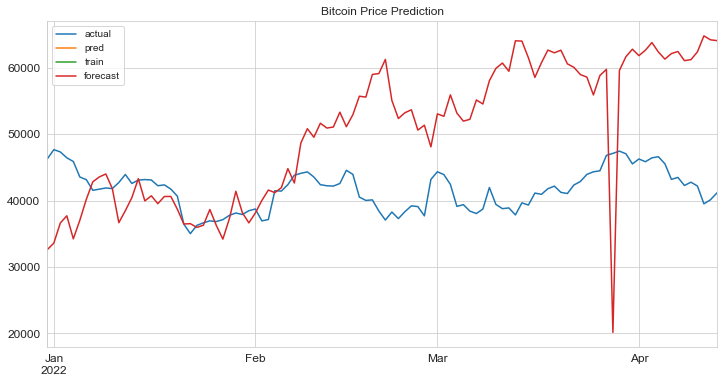

In [91]:
# compare predicted values with actual values
mask = (future.index >= df.index[-1]) & (future.index <= yf_df.index[-1])
filter = future.loc[mask]
filter.plot(figsize=(12, 6), title='Bitcoin Price Prediction', grid=True, legend=True, fontsize=12)

# The lower the MSE, the better the forecast.
forecast_accuracy(filter['forecast'], filter['actual'])


In [70]:
def plot_future(past, predicted, actual):
    plt.figure(figsize=(12, 8))
    plt.plot(predicted, label='Predicted Stock Price')
    plt.plot(actual, color='g', label='Actual Future Stock Price')
    plt.plot(past, color='r', label='Actual Stock Price')

    plt.axvline(x=max(past.index),
                color='green', linewidth=2, linestyle='--')
    plt.xticks(rotation=45, fontsize=8)
    plt.legend(shadow=True, loc='upper right')


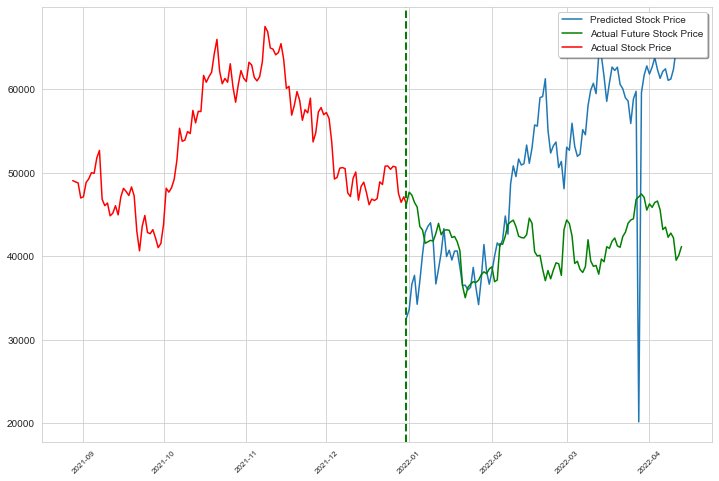

In [92]:
plot_future(df[1700:].close, filter['forecast'], filter['actual'])


<AxesSubplot:title={'center':'Bitcoin Price Prediction'}, xlabel='date'>

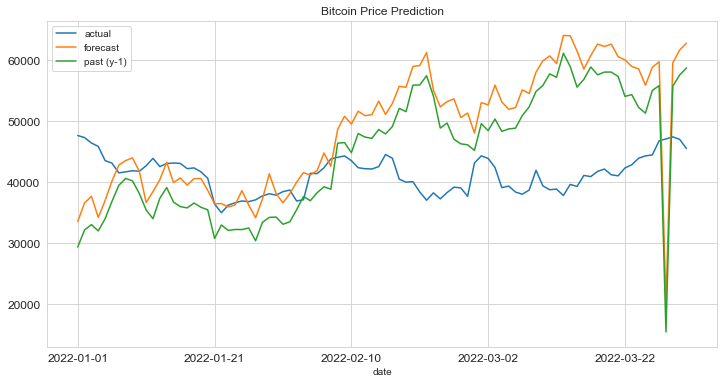

In [97]:
cc = []
for i in range(1, 32):
    for j in range(1, 4):
        try:
            d = f'2022-0{j}-{i < 10 and f"0{i}" or i}'
            cc.append({'date': d, 'forecast': future.iloc[future.index == d]['forecast'].values[0],
                       'actual': yf_df.iloc[yf_df.index == d]['Close'].values[0], 'past (y-1)': df.iloc[df.index == f'2021-0{j}-{i < 10 and f"0{i}" or i}']['close'].values[0]})
        except IndexError as e:
            continue

y_april = pd.DataFrame(cc, columns=['date','actual', 'forecast','past (y-1)'])
y_april.set_index('date', inplace=True)
y_april.sort_index(inplace=True)
y_april.plot(figsize=(12, 6), title='Bitcoin Price Prediction', grid=True, legend=True, fontsize=12)


In [98]:
y_april

,actual,forecast,past (y-1)
date,,,
2022-01-01,47686.812500,33603.986785,29405.123461
2022-01-02,47345.218750,36634.871290,32216.530000
2022-01-03,46458.117188,37718.370091,33071.500000
2022-01-04,45897.574219,34246.387612,32042.188855
2022-01-05,43569.003906,37043.589331,34043.030762
...,...,...,...
2022-03-27,46820.492188,59785.122954,55868.769462
2022-03-28,47128.003906,20147.479380,15470.656119
2022-03-29,47465.730469,59621.172771,55780.246000


In [99]:
forecast_accuracy(y_april['forecast'], y_april['actual'])

{'mape': '24.351%',
 'me': 7433.775744528841,
 'mae': 10035.040257678564,
 'mpe': 0.18562823757918462,
 'rmse': 12614.085714181418,
 'corr': 0.01401822203657167,
 'minmax': 0.1827131103856955}

The results indicate that the model is still a little rough and not something we should use as trading advice, but that was not unexpected due to the extremely volatile nature of cryptocurrencies, especially in the last 6 months.

It is probably also not such a good idea to try and predict 6 months into the future as we can see how insane even the 80% confidence interval becomes out this far. Maybe sticking to 1 month advance predictitons is more sensible. Or maybe even predicting on a daily basis.

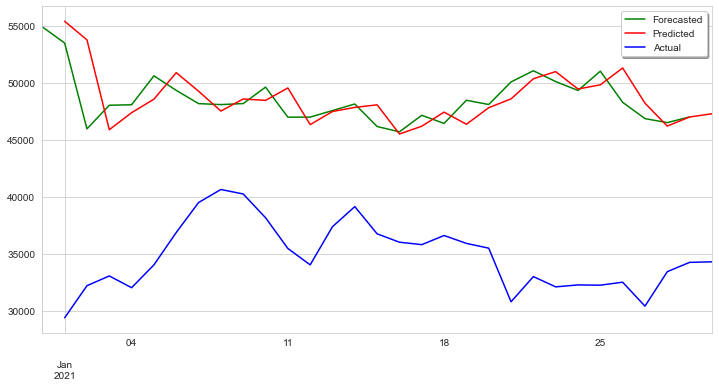

In [78]:
fit_res.get_forecast(steps=30, exog=exog_last[-30:]).predicted_mean.plot(figsize=(12, 6), label='Forecasted', color='green')
fit_res.get_prediction(start=pd.to_datetime('2021-01-01'), end=pd.to_datetime('2021-01-30'),
                       exog=exog_last[-31:]).predicted_mean.plot(figsize=(12, 6), label='Predicted', color='red')

z = (df.index >= '2021-01-01') & (df.index <= '2021-01-30')
df.loc[z]['close'].plot(figsize=(12, 6), label='Actual', color='blue')
plt.legend(shadow=True, loc='upper right')